#Cargar librerias


In [ ]:
import os
import cv2
from glob import glob
from scipy.io import loadmat
import cv2
from PIL import Image

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.api._v2.keras.layers import Normalization

import numpy as np

from IPython.display import clear_output
import matplotlib.pyplot as plt



In [ ]:
BATCH_SIZE = 8
seed=42
IMAGE_SIZE = 224
NUM_CLASSES = 4
DATA_DIR = "/content/drive/MyDrive/MIoT/TFM"
NUM_TRAIN_IMAGES= 323
#376
#323
NUM_TEST_IMAGES = 79
#96
#79

# Generar los datos

In [ ]:


train_images = sorted(glob(os.path.join(DATA_DIR, "train_img/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "train_mask_ids/*")))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(DATA_DIR, "test_img/*")))[:NUM_TEST_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "test_mask_ids/*")))[:NUM_TEST_IMAGES]

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):

    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data,num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>
Val Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>


# Aumentar los datos

In [ ]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()

        self.augment_inputs = [
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(factor=0.25, fill_mode="wrap", seed=seed),
            tf.keras.layers.RandomTranslation(height_factor=0.25, width_factor=0.25, fill_mode="wrap", seed=seed),
            tf.keras.layers.RandomZoom(height_factor=(-0.3, -0.2), fill_mode="wrap", seed=seed)
        ]

        self.augment_labels = [
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(factor=0.25, fill_mode="wrap", seed=seed),
            tf.keras.layers.RandomTranslation(height_factor=0.25, width_factor=0.25, fill_mode="wrap", seed=seed),
            tf.keras.layers.RandomZoom(height_factor=(-0.3, -0.2), fill_mode="wrap", seed=seed)
        ]

    def call(self, inputs, labels):
        augmented_inputs = [inputs]
        augmented_labels = [labels]

        for augment_input in self.augment_inputs:
            augmented_inputs.append(augment_input(inputs))

        for augment_label in self.augment_labels:
            augmented_labels.append(augment_label(labels))

        augmented_inputs = tf.stack(augmented_inputs)
        augmented_labels = tf.stack(augmented_labels)

        return augmented_inputs, augmented_labels


# Crear 'batch'

In [ ]:
train_batches = (
    train_dataset
    .map(Augment())
    .unbatch()
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


test_batches = val_dataset.batch(BATCH_SIZE)

In [ ]:
print("Train Dataset:", train_batches)
print("Val Dataset:", test_batches)

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>


# Visualizar los datos aumentados


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):

    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

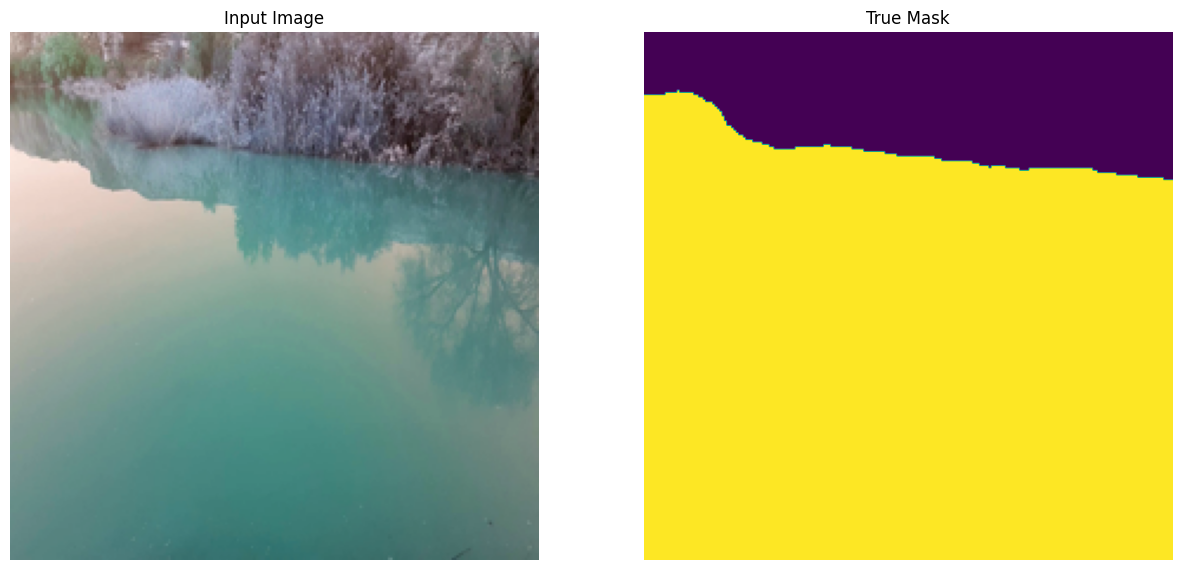

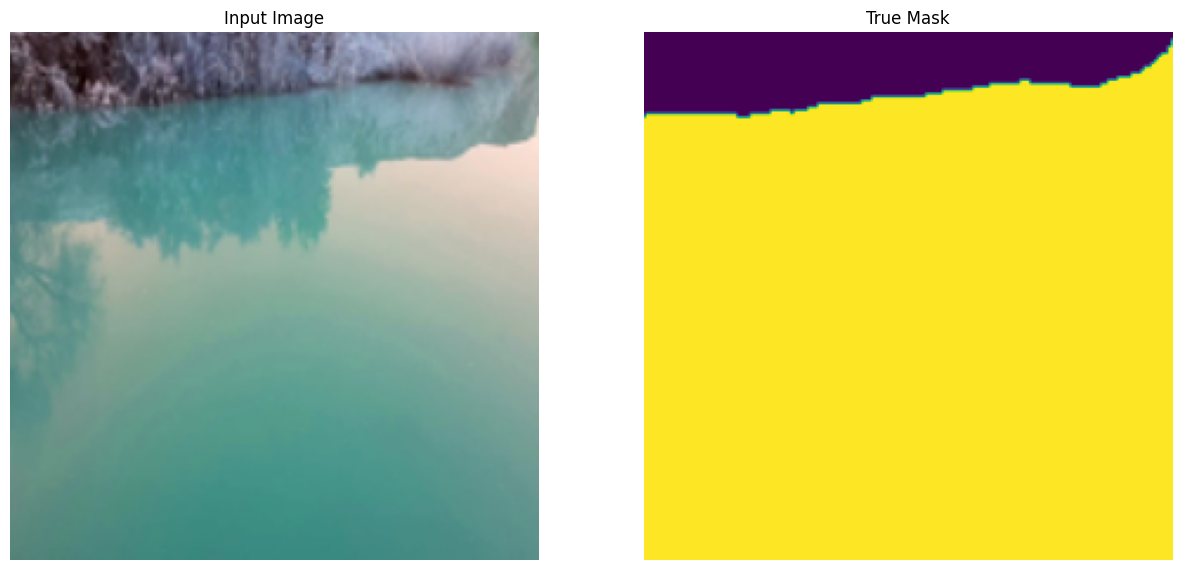

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[1], masks[1]
  #list_id_gray= list(np.unique(masks[0]))
  #print(list_id_gray)
  display([sample_image, sample_mask])

In [ ]:
print("Train Dataset:", train_batches)
print("Val Dataset:", test_batches)

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>


# Construir el modelo

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 =keras.applications.DenseNet201(
        weights="imagenet", include_top=False, input_tensor=model_input
    )

    x = resnet50.get_layer("pool4_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)

    input_b = resnet50.get_layer("pool2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

74836368/74836368 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

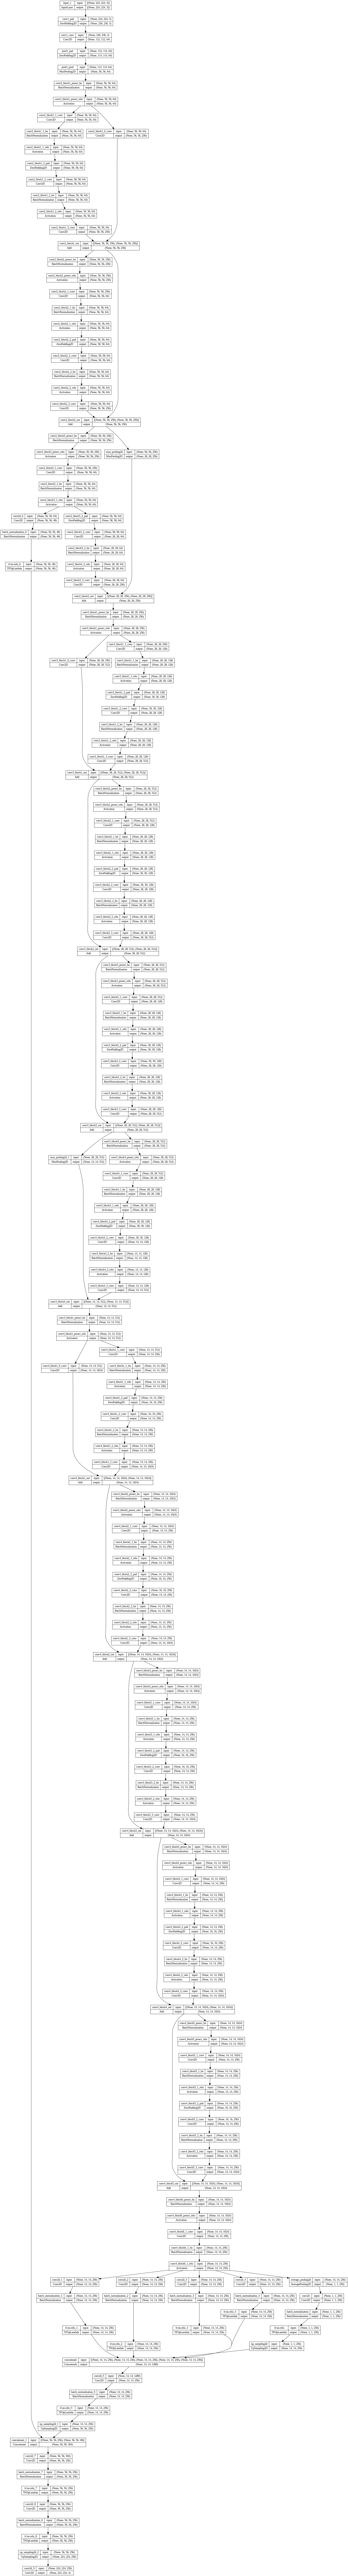

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

# Entrenar el modelo

In [ ]:
VALIDATION_STEPS= NUM_TEST_IMAGES // BATCH_SIZE
STEPS_PER_EPOCH = (NUM_TRAIN_IMAGES *5) // BATCH_SIZE
print('VALIDATION_STEPS:', VALIDATION_STEPS)
print('STEPS_PER_EPOCH:', STEPS_PER_EPOCH)

VALIDATION_STEPS: 9
STEPS_PER_EPOCH: 201


In [ ]:
initial_learning_rate = 0.0003
decay_steps = 150
decay_rate = 0.94

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=lr_schedule),
    loss= loss,
    metrics= [
              tf.keras.metrics.IoU(num_classes=4, target_class_ids=[1], sparse_y_true = True, sparse_y_pred = False),
              tf.keras.metrics.IoU(num_classes=4, target_class_ids=[2], sparse_y_true = True, sparse_y_pred = False),
              tf.keras.metrics.MeanIoU(num_classes=4, sparse_y_true = True, sparse_y_pred = False)],
)

history = model.fit(train_batches, epochs=80, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,validation_data=test_batches)
model.save('/content/drive/MyDrive/MIoT/TFM/Modelos_finales/with_DenseNet201_dt1_decay.tf') #> acceso a .predict method

Epoch 1/80
201/201 [==============================] - 462s 2s/step - loss: 0.6596 - io_u: 0.2707 - io_u_1: 0.7246 - mean_io_u: 0.3895 - val_loss: 2.3076 - val_io_u: 0.2561 - val_io_u_1: 0.4874 - val_mean_io_u: 0.2740
Epoch 2/80
201/201 [==============================] - 89s 358ms/step - loss: 0.5432 - io_u: 0.1913 - io_u_1: 0.7335 - mean_io_u: 0.4060 - val_loss: 0.7639 - val_io_u: 0.2577 - val_io_u_1: 0.5560 - val_mean_io_u: 0.4045
Epoch 3/80
201/201 [==============================] - 72s 357ms/step - loss: 0.4834 - io_u: 0.2271 - io_u_1: 0.7358 - mean_io_u: 0.4364 - val_loss: 0.5720 - val_io_u: 0.2930 - val_io_u_1: 0.6105 - val_mean_io_u: 0.5920
Epoch 4/80
201/201 [==============================] - 71s 351ms/step - loss: 0.4417 - io_u: 0.3187 - io_u_1: 0.7562 - mean_io_u: 0.4729 - val_loss: 0.4024 - val_io_u: 0.4071 - val_io_u_1: 0.7708 - val_mean_io_u: 0.6796
Epoch 5/80
201/201 [==============================] - 70s 347ms/step - loss: 0.4018 - io_u: 0.3515 - io_u_1: 0.7711 - mean_io_

# Gráficas 'Loss' y 'IoU'

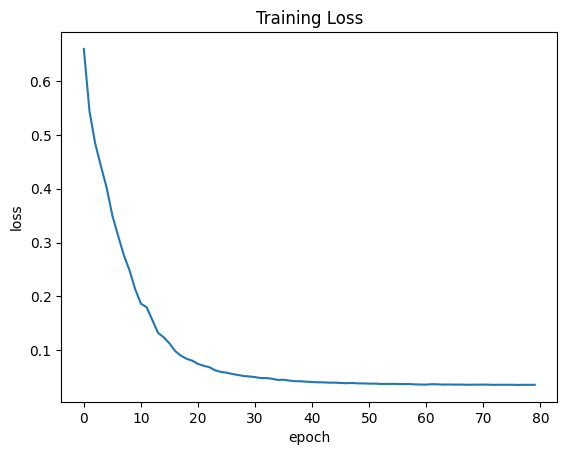

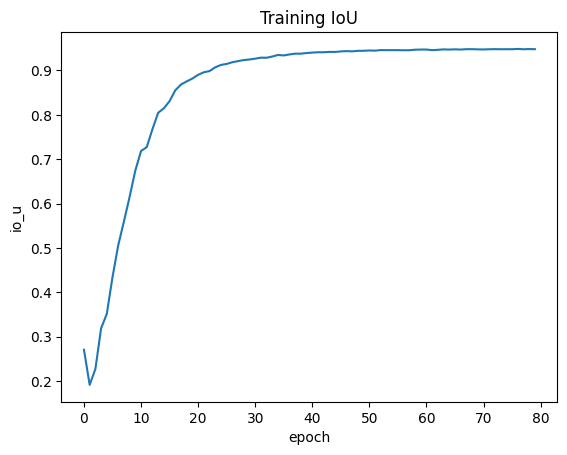

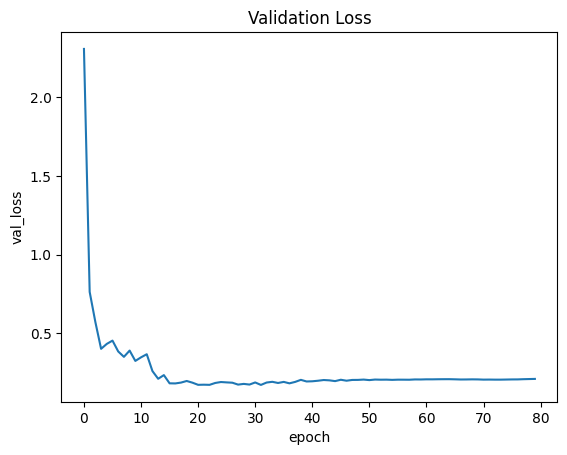

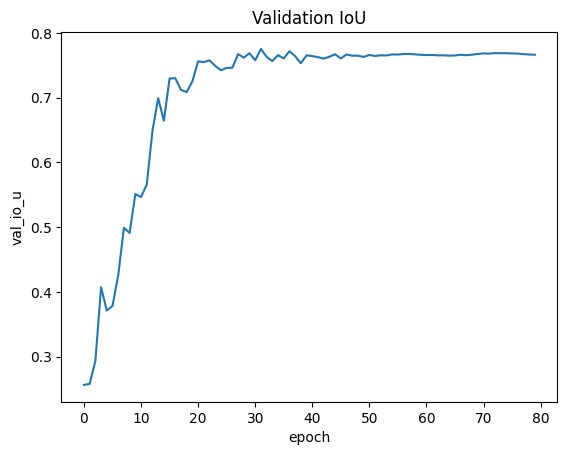

In [ ]:

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["io_u"])
plt.title("Training IoU")
plt.ylabel("io_u")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()


plt.plot(history.history["val_io_u"])
plt.title("Validation IoU")
plt.ylabel("val_io_u")
plt.xlabel("epoch")
plt.show()

# Métricas evaluación

In [ ]:
def compute_metrics(y_true, y_pred):

  class_wise_iou = []
  class_wise_dice_score = []
  list_labels_id = []

  smoothening_factor = 0.00001

  list_id= list(np.unique(y_true))
  dicc_id= {0:'Fondo',1:'Agua', 2:'Cianobacterias', 3:'Rocas'}


  for i in list_id:
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  (2 *(intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)
    list_labels_id.append(dicc_id[i])

  return class_wise_iou, class_wise_dice_score, list_labels_id


Visualización: predicción vs ground truth

In [ ]:
colormap = np.array([[0,0,0],[255,50,50],[214,255,50],[50,255,132]])
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, display_string, figsize=(5, 4)):
    fig, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    title = ['Input Image', 'Predicted Mask + Input Image ','Predicted Mask', 'True Mask']
    for i in range(len(display_list)):

        if display_list[i].shape[-1] == 3:
            axes[i].title.set_text(title[i])

            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))

        else:
            axes[i].imshow(display_list[i])

    fig.text(0.5, 0.3,display_string, horizontalalignment='center',
     verticalalignment='bottom')
    plt.show()


def plot_predictions(images_list, ground_truth_list, colormap, model):
    for image_file, ground_truth_file in zip(images_list, ground_truth_list):
        image_tensor = read_image(image_file)
        ground_truth_tensor = read_image(ground_truth_file, mask=True)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 4)
        ground_truth_mask =  np.squeeze(ground_truth_tensor).astype(np.uint8)
        ground_truth_colormap = decode_segmentation_masks(ground_truth_mask, colormap, 4)
        overlay = get_overlay(image_tensor, prediction_colormap)
        iou_list, dice_score_list, labels_id = compute_metrics(ground_truth_mask,prediction_mask)
        metrics_by_id = [(idx, iou, dice_score) for i, (idx,iou, dice_score) in enumerate(zip(iou_list, dice_score_list, labels_id)) if iou > 0.0]
        display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for iou, dice_score, idx in metrics_by_id]
        display_string = "\n\n".join(display_string_list)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap,ground_truth_colormap], display_string, figsize=(18, 14)
        )

1/1 [==============================] - 5s 5s/step


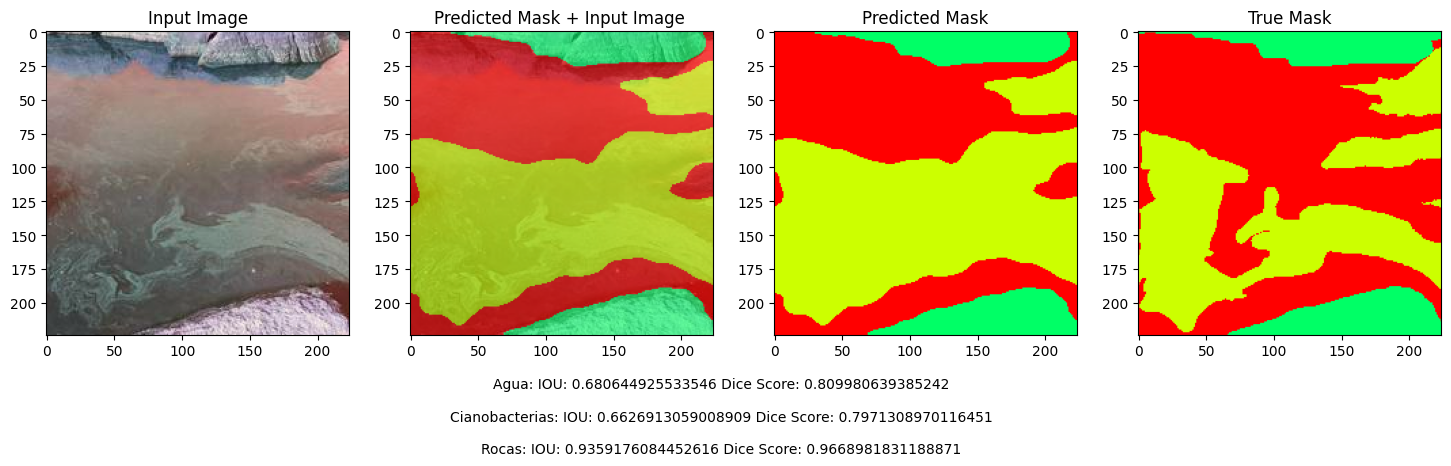

In [ ]:
plot_predictions(train_images[:1], train_masks[:1], colormap, model=model)

1/1 [==============================] - 4s 4s/step


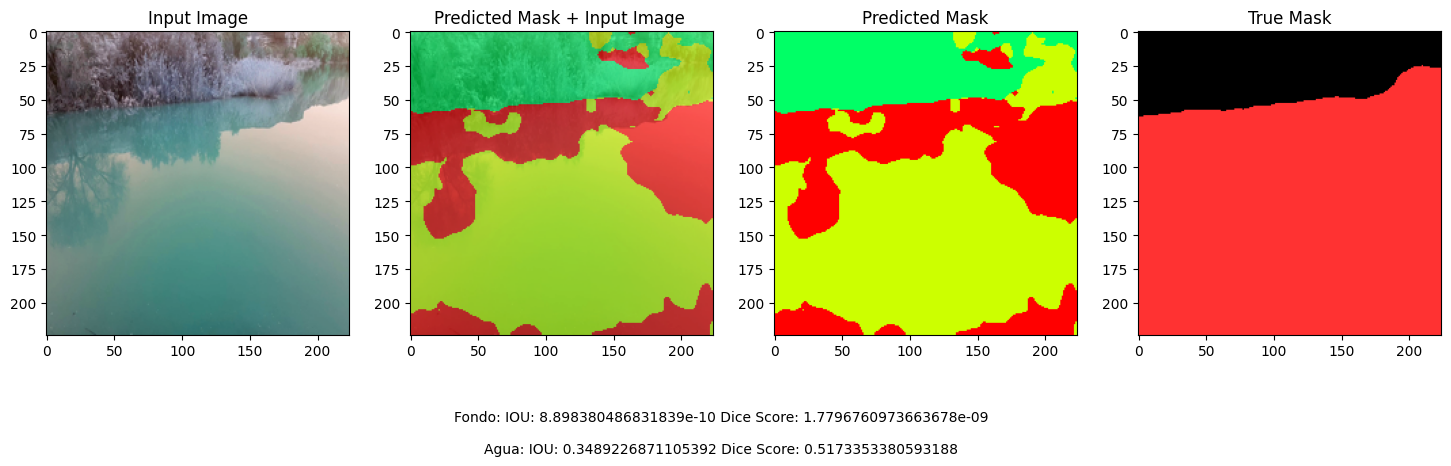

1/1 [==============================] - 0s 39ms/step


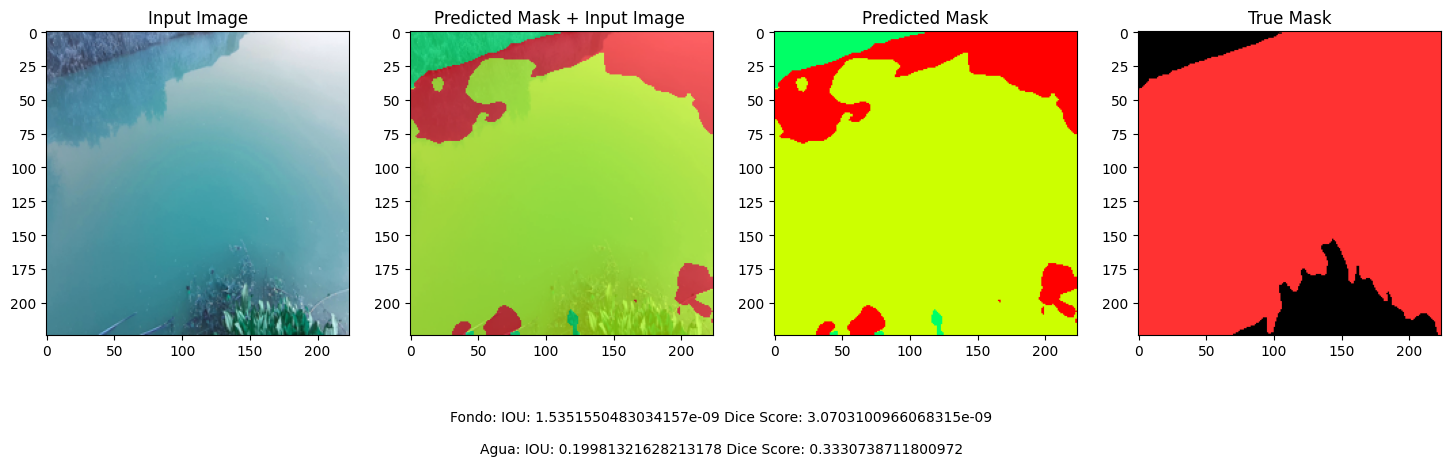

1/1 [==============================] - 0s 47ms/step


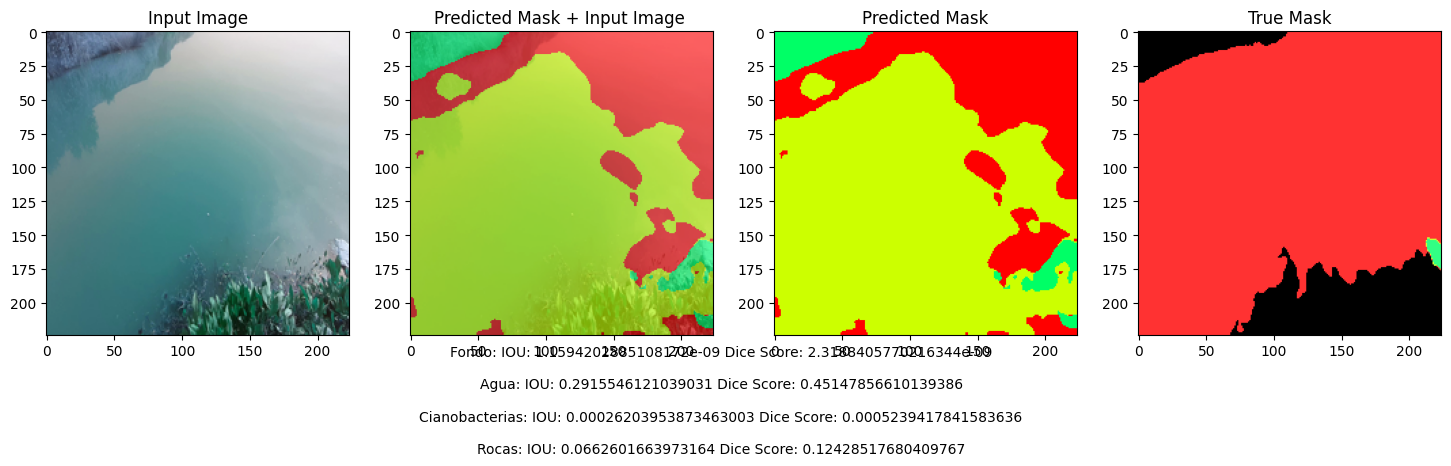

In [ ]:
plot_predictions(val_images[:3], val_masks[:3], colormap, model=model)